# SPECFEM Users Workshop -- Day 3 (Oct. 7, 2022)

## Part 3A: Seismic Imaging (Simple)

- In this notebook we will bring all of the previous material together run a seismic inversion to update a starting model   
- **Objective**: Manually update a velocity model and assess change in misfit   
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble* in Day 0)  

-----------

**Relevant Links:** 
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_3a_imaging_simple.ipynb
- Completed Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_3a_imaging_simple.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_0_container_testing.ipynb
- Day 1A Notebook (Intro SPECFEM): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem2d.ipynb
- Day 1B Notebook (Fwd. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb
- Day 2A Notebook (Adj. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2a_kernels.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.


## 1) Run a SeisFlows Example Problem

- We will use SeisFlows to automate an inversion workflow **up to** kernel generation, to save time  
- SeisFlows will run a forward simulation, calculate misfit, and run an adjoint simulation for one source and one receiver
- *Starting model*: homogeneous halfspace / *Target model*: perturbation checkerboard.
- **Objective**: Quickly generate an event kernel that we can use to manually update a 2D model  

In [1]:
# Required Python packages for today's notebook
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import Image
from scipy.integrate import simps
from seisflows.tools.specfem import Model, read_fortran_binary, write_fortran_binary

In [2]:
# Make sure we're in an empty working directory
! rm -r /home/scoped/work/day_3/sfexample_2
! mkdir -p /home/scoped/work/day_3/sfexample_2
%cd /home/scoped/work/day_3/sfexample_2

# Run the example and stop after adjoint simulation
! seisflows examples setup 2 -r /home/scoped/specfem2d --event_id 1 --nsta 1 --niter 1 --with_mpi
! seisflows par stop_after evaluate_gradient_from_kernels
! seisflows submit

rm: cannot remove '/home/scoped/work/day_3/sfexample_2': No such file or directory
/home/scoped/work/day_3/sfexample_2

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                

-----------

You will know that this workflow has completed successfully after the final log message   

```bash
2022-09-16 19:57:07 (I) | stop workflow at `stop_after`: evaluate_gradient_from_kernels
```

-----------
## 2) Manually Update the Starting Model

- SeisFlows has automatically generated an event kernel for us  
- To provide context we will first visualize the starting and target models, as well as the kernel generated
- **Objective**: Use the event kernel generated by SeisFlows to update the initial model. 

>__MODEL UPDATE:__ The Model update equation *can be* as simple as: $m_{i+1} = m_{i} - \alpha \times g$; where $m_{i}$ is the current model, $m_{i+1}$ is the updated model, $g$ is the gradient and $\alpha$ is a scale factor.

In [3]:
# Incase participants get lost, each numbered section 
# contains the absolute work dir path
%cd /home/scoped/work/day_3/sfexample_2

/home/scoped/work/day_3/sfexample_2


### a) Initial Model ($m_i$) and Target Model ($m_{true}$)

- The **initial/starting** model is a *homogeneous halfspace* model  
- It defines a region with P-wave velocity 5.8km/s and S-wave velocity 3.5km/s  
- The **target/true** model is a *perturbation checkerboard* model  
- Perturbations are roughly $\pm$10\% of the initial homogeneous halfspace Vp and Vs models  
- The target model is used to generate 'data', which mimics real-world observations  
- We have seen both of these models on Days 1 and 2  


INITIAL MODEL
vs: [[3500. 3500. 3500. ... 3500. 3500. 3500.]]
vp: [[5800. 5800. 5800. ... 5800. 5800. 5800.]]



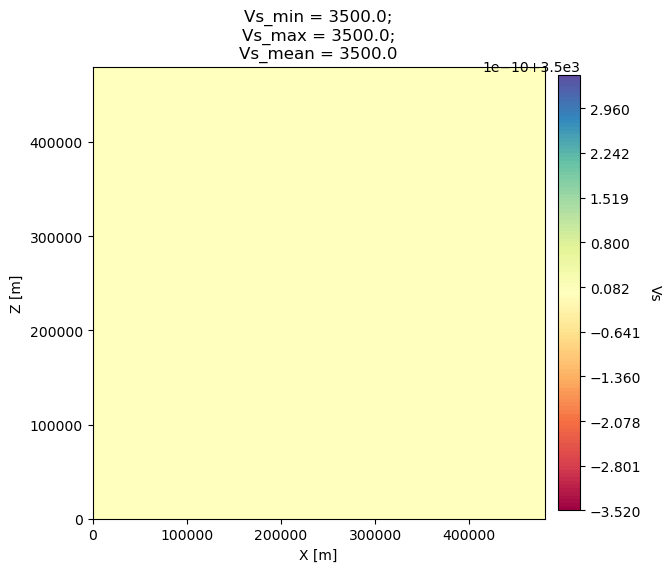

In [4]:
# Plot in the initial model Vs model
m_init = Model("output/MODEL_INIT")
print(f"INITIAL MODEL\n{m_init.model}")
m_init.plot2d("vs")

TARGET MODEL
vs: [[3500.  3500.  3500.  ... 3697.8 3708.6 3713.9]]
vp: [[5800.  5800.  5800.  ... 5961.4 5970.3 5974.8]]



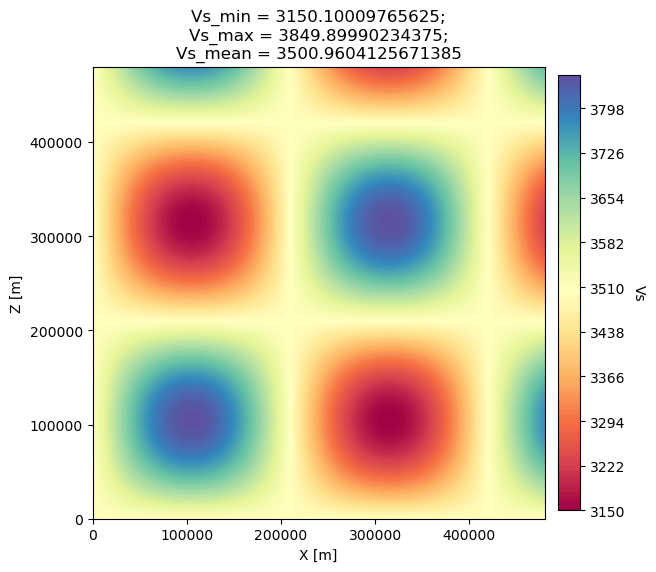

In [5]:
# Plot in the target model Vs model
m_true = Model("output/MODEL_TRUE")
print(f"TARGET MODEL\n{m_true.model}")
m_true.plot2d("vs")

### b) Event Kernel

- The **event kernel** is generated through the interaction of the forward and adjoint wavefields  
- It is a volumetric quantity proportional to the gradient of the misfit function and provides a *search direction* for model update  
- Multiple event kernels summed together form the **misfit kernel**. Because we only have one event, the event and misfit kernels are the same  
- SeisFlows has already *smoothed* the kernel with a 2D Gaussian of vertical and horizontal half-widths equal to 5km

GRADIENT
vp_kernel: [[0. 0. 0. ... 0. 0. 0.]]
vs_kernel: [[-1.0636849e-08 -1.6986203e-08 -3.1655802e-08 ...  9.9895852e-09
   2.6388767e-08  3.1614960e-08]]



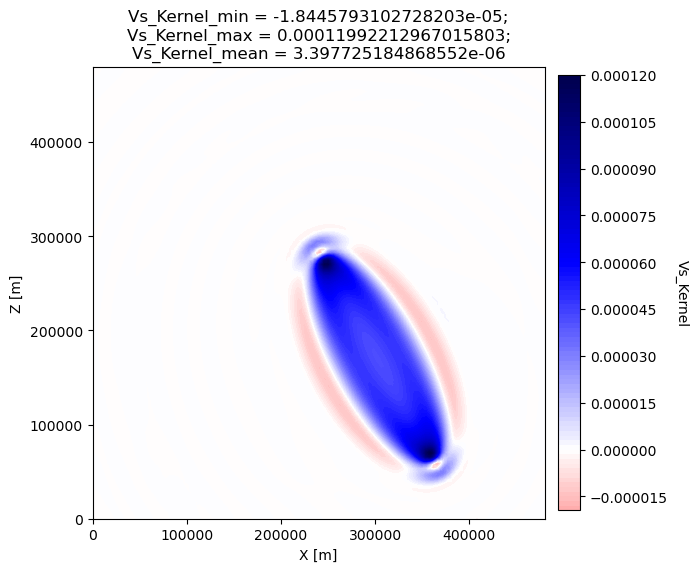

In [6]:
# Load in Gradient binary files using SeisFlows
gradient = Model("output/GRADIENT_01")

# Assign coordinate information which is used for plotting
# We do this because the Gradient output directory does not contain coordinate information, 
# so we need to grab it from the model
gradient.coordinates = {}
gradient.coordinates["x"] = m_init.coordinates["x"]
gradient.coordinates["z"] = m_init.coordinates["z"]

print(f"GRADIENT\n{gradient.model}")
gradient.plot2d("vs_kernel")

### c) Updated Model ($m_{i+1}$)

- We generate an updated model by scaling the gradient and adding the negative gradient to the initial model  
- The gradient represents positive change, so we want to use the inverse gradient to reduce misfit  
- We use the equation $m_{i+1} = m_{i} - \alpha \times g$ to update the model  
- **Objective**: First we will **not** scale the gradient (i.e., $\alpha$==1)  

vp: [[5800. 5800. 5800. ... 5800. 5800. 5800.]]
vs: [[3500.00000001 3500.00000002 3500.00000003 ... 3499.99999999
  3499.99999997 3499.99999997]]



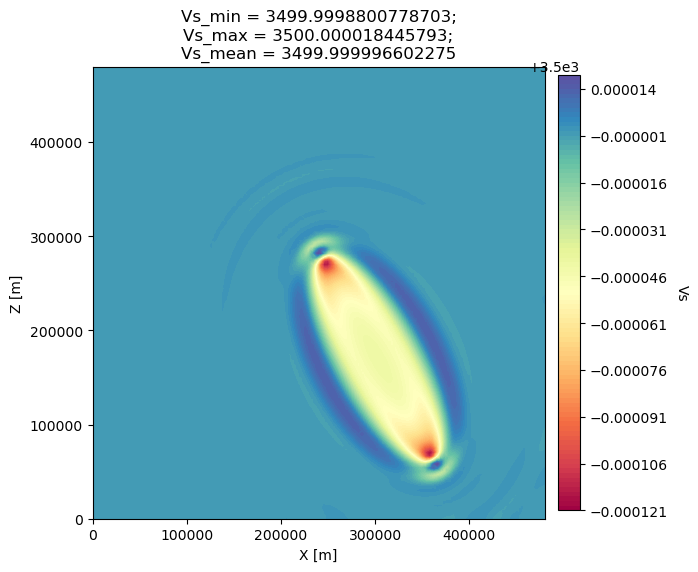

In [7]:
# We can use the SeisFlows Model class to update the model directly
m_update = m_init.copy()

# No scaling is applied here (alpha==1)
m_update.update(vector=m_init.vector - gradient.vector)

print(m_update.model)

# Plot the updated Vs model
m_update.plot2d("vs")

- We can see the gradient is **not** well scaled, so model updates only make slight changes to the Vs model (roughly $\pm.0001$m/s, see figure title). 
- In order to make significant changes to the starting model, we need the **scale** the gradient. 
- There are many algorithms which provide scaling estimates for the gradient. 

--------------

For an initial scaling guess, we can scale by: [G$^T$G]$^{-1}$ (i.e,. where G is the gradient)


GTG^-1 = 130472.26
vp: [[5800. 5800. 5800. ... 5800. 5800. 5800.]]
vs: [[3500.00138781 3500.00221623 3500.0041302  ... 3499.99869664
  3499.996557   3499.99587512]]



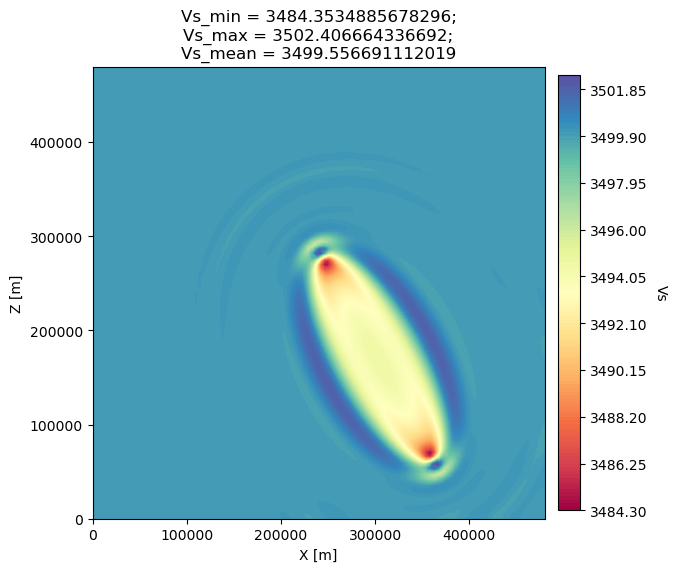

In [8]:
# Calculate GTG^-1
gtg = np.dot(gradient.vector, gradient.vector)
gtg_inverse = gtg ** -1 
print(f"GTG^-1 = {gtg_inverse:.2f}")

# Update the starting model with the scaled gradient
m_update = m_init.copy()
m_update.update(vector=m_init.vector - (gtg_inverse * gradient.vector))
print(m_update.model)

# Plot the model updated by the scaled gradient
m_update.plot2d("vs")

- The gradient is now more well scaled, and has updated our velocity model by at most 25m/s (see figure title). 
- Let's use this updated velocity model to generate **new** synthetics

--------------
## 3) Run Forward Simulations w/ Updated Model

- In Section 2c we generated an updated model, stored in the Python parameter `m_update`. 
- We want to use this updated model to generate a new set of synthetics

In [9]:
# Setup block for our SPECFEM2D working directory
! rm -r /home/scoped/work/day_3/specfem2d_workdir
! mkdir -p /home/scoped/work/day_3/specfem2d_workdir
%cd /home/scoped/work/day_3/specfem2d_workdir

rm: cannot remove '/home/scoped/work/day_3/specfem2d_workdir': No such file or directory
/home/scoped/work/day_3/specfem2d_workdir


### a) Setup SPECFEM2D working directory
- We first set up a new SPECFEM2D working directory where we can run SPECFEM manually
- Our objective here is to run generate synthetics manually using our new model
- This task is very similar to what we did in Day 1  

In [10]:
# Symlink the binary files located in bin/
! ln -s /home/scoped/specfem2d/bin .
# Copy over the DATA/ directory with Par_file, SOURCE and STATIONS
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
# Pick a pre-defined Par_file set up for the homogeneous halfspace model
! cp DATA/Par_file_Tape2007_onerec DATA/Par_file
# Ensure we are using SOURCE #1
! cp DATA/SOURCE_001 DATA/SOURCE
# Ensure we are using only STATION #1
! head -1 DATA/STATIONS_checker > DATA/STATIONS
# Create the output directory required by SPECFEM
! mkdir OUTPUT_FILES

! ls

bin  DATA  OUTPUT_FILES


### b) Run SPECFEM2D to get initial model synthetics

- First we will run SPECFEM2D to get the initial model ($m_i$) synthetics
- Later we'll compare these to the updated model ($m_{i+1}$) synthetics


In [11]:
# Tell SPECFEM to output FORTRAN binary files, and use the STATIONS file
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.

# Run SPECFEM with the homogeneous halfspace model, 1 source, 1 station
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

# A succesfully completed solver will write data files, expressed in the log
! tail -n 30 OUTPUT_FILES/output_solver.txt

SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
use_existing_STATIONS: .false. -> .true.
 Average duration of the calculation per spectral element =    4.67255859E-07  s


 Total duration of the timeloop in seconds, measured using 
 date and time of the system :    3.89400005      s

 Saving model files to directory: ./DATA/
   SAVE_MODEL type: binary

   written to file(s): ./DATA/proc000000_rho.bin
   written to file(s): ./DATA/proc000000_vp.bin
   written to file(s): ./DATA/proc000000_vs.bin
   written to file(s): ./DATA/proc000000_x.bin
   written to file(s): ./DATA/proc000000_z.bin
   written to file(s): ./DATA/proc000000_jacobian.bin

   done


 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -----------------------------------------------------------

### c) Set the Updated Model as the 'Current' Model

- SPECEFM2D needs to be able to find the updated model we created in Section 3c
- SPECFEM2D expects model files to be in the DATA/ directory. 
- **SPECFEM3D NOTE**: SPECFEM3D expects model files to be in the `LOCAL_PATH` directory, usually located in *OUTPUT_FILES/DATABASES_MPI*
- We can use SeisFlows utilities to write these files in SPECFEM-readable formats
- We will OVERWRITE updated parameters (here Vp and Vs) and leave the remainder of the model the same
- **IMPORTANT**: The `Par_file` parameter 'MODEL' must be set to `gll`, which tells SPECFEM to read the updated model files we have written

In [12]:
# First make sure that the original model files are stored somewhere safe
! mkdir MODEL_INIT
! cp -r DATA/*bin MODEL_INIT
! cp -r OUTPUT_FILES/*semd MODEL_INIT

print(f"parameters to be updated are: {m_update.parameters}")

# SeisFlows will overwrite the 'Vp' and 'Vs' binary files
m_update.write(path="DATA")

# Update the `Par_file` parameter 'MODEL' to tell SPECFEM to read model files from DATA/
! seisflows sempar -P DATA/Par_file model gll

parameters to be updated are: ['vp', 'vs']
MODEL: default -> gll


### d) Run Forward Simulations with Updated Model

- We can now run `xmeshfem2D` and `xspecfem2D` to retrieve synthetics for our updated model
- Because we updated *model* files, we need to **rerun** `xmeshfem2D`. 
- Since we set `MODEL`==`gll`, SPECFEM2D will know to read the **updated** model files we just wrote (rather than reading internal files)
- The forward simulation **overwrites** existing files stored in `OUTPUT_FILES/`

In [13]:
# Re-run the mesher and solver with the updated velocity model
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher_update.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver_update.txt

# Confirm that the updated model was used during the simulation
! head -236 OUTPUT_FILES/output_solver_update.txt | tail -n 15

# Make sure that the updated model files are stored somewhere safe
! mkdir MODEL_UPDATE
! cp -r DATA/*.bin MODEL_UPDATE
! cp -r OUTPUT_FILES/*semd MODEL_UPDATE

 Material properties:
   MODEL                 : gll
   nspec                 :         1600
   assign external model :  T

   assigning an external velocity and density model
   model selected             : gll
   setup with binary database :            1

   reading external files: DATA/proc*****_rho.bin, .._vp.bin, .._vs.bin
   rho min/max =    2600.00000       2600.00000    
   vp  min/max =    5800.00000       5800.00000    
   vs  min/max =    3484.35352       3502.40674    

   done reading external model


## 5) Comparing Synthetics for Initial and Updated Models

- We now have 2 synthetic seismograms. 1 for the initial model, 1 for the updated model  
- In a real inversion, we would have 2$\times$N seismograms, corresonding to N stations  
- Our first goal is to quantify misfit of the new synthetics against the True model synthetics (checkerboard model)  
- **Objective**: Determine if we have reduced waveform misfit through model update  

In [14]:
%cd /home/scoped/work/day_3/specfem2d_workdir

/home/scoped/work/day_3/specfem2d_workdir


### a) Compare Initial and Updated synthetics

- We first want to see if the model update changed the synthetic waveforms
- We'll re-use some code snippets from Day 2 to plot synthetics
- Plot colors are:
    - Initial model synthetics: *red*
    - Updated model synthetics: *purple*
    - Initial - Update (waveform difference): *blue*

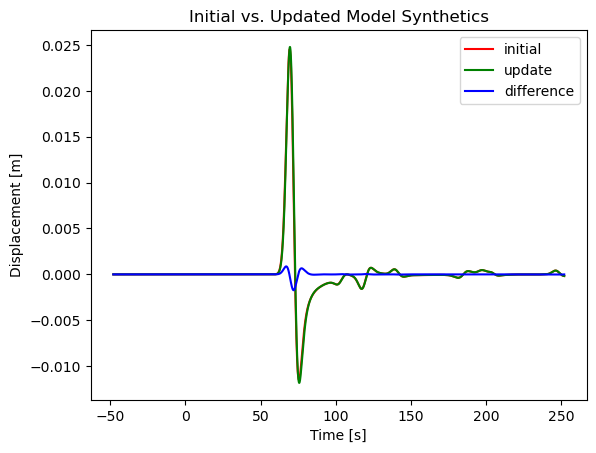

In [15]:
def plot_waveforms(t, data, labels, colors):
    """Re-usable function to plot synthetic waveforms"""
    for i, d in enumerate(data):
        plt.plot(t, d, c=colors[i], label=labels[i])
    plt.xlabel("Time [s]")
    plt.ylabel("Displacement [m]")
    plt.legend()  
    
# Load in the initial, updated synthetics, calculate waveform difference
t_init, d_init = np.loadtxt("MODEL_INIT/AA.S000000.BXY.semd").T
t_update, d_update = np.loadtxt("MODEL_UPDATE/AA.S000000.BXY.semd").T
d_diff = d_init - d_update 

plot_waveforms(t=t_init, data=[d_init, d_update, d_diff],
               labels=["initial", "update", "difference"],
               colors=["r", "g", "b"])

plt.title("Initial vs. Updated Model Synthetics")
plt.show()

If we zoom into the time window where the two waveforms are different, we can better identify how the model update has affected the synthetic waveforms.
The time window of waveform difference (min/max amplitude of the blue wiggle) spans roughly *T0=60s* to *T1=85s*

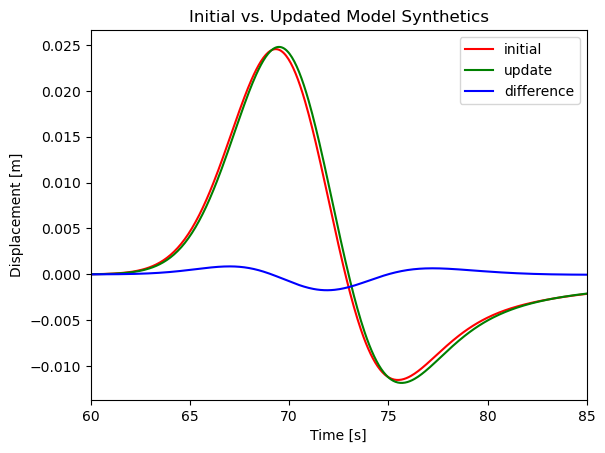

In [16]:
plot_waveforms(t=t_init, data=[d_init, d_update, d_diff],
               labels=["initial", "update", "difference"],
               colors=["r", "g", "b"])

plt.xlim([60, 85])
plt.title("Initial vs. Updated Model Synthetics")
plt.show()

In [17]:
# Print min/max values to see if model update has affected waveform amplitude
print(f"INITIAL MODEL WAVEFORM: \n   MIN={d_init.min():.3f}; MAX={d_init.max():.3f}")
print(f"TARGET MODEL WAVEFORM:  \n   MIN={d_update.min():.3f}; MAX={d_update.max():.3f}")

INITIAL MODEL WAVEFORM: 
   MIN=-0.012; MAX=0.025
TARGET MODEL WAVEFORM:  
   MIN=-0.012; MAX=0.025


#### Understanding waveform differences

- Visually the waveforms look almost the same  
- Zooming in on the time window of waveform difference shows small waveform differences  
- The updated synthetics (green) are slightly *delayed* with respect to the initial model synthetics (red)  
- Updated synthetics (green) also have slightly larger minimum and maximum amplitudes w.r.t. initial model (red)  


### b) Generate 'Data' using True/Target Model Synthetics

- We want to compare our two sets of synthetics against 'data'
- 'Data', generated by the checkerboard model, was already created by SeisFlows in Section 2
- However we perform this manually here to re-iterate using the input checkerboard model

In [18]:
# This new par file OVERWRITES the changes we made previously 
! cp -f DATA/Par_file_Tape2007_132rec_checker DATA/Par_file

# Overwrite some default parameters
! seisflows sempar -P DATA/Par_file NSTEP 5000  # 4800 -> 5000 to match the other Par_file

# Ensure that SPECFEM can find the checkerboard model by name
! cp -f DATA/model_velocity.dat_checker DATA/proc000000_model_velocity.dat_input

# Re-run mesher and solver for the Target model
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher_true.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver_true.txt

# Copy waveforms and model into safe place
! mkdir -p MODEL_TRUE
! cp -r OUTPUT_FILES/*semd MODEL_TRUE

NSTEP: 4800 -> 5000


### c) Quantify Misfit between Initial/Update synthetics and Target model data

- We can now plot the target model data on top of the waveforms we showed earlier  
- Target model synthetics (i.e., 'data') are generated using the checkerboard model  
- Plot colors are:  
    - Initial model synthetics: *red*  
    - Updated model synthetics: *purple*  
    - Initial - Update (waveform difference): *blue*  
    - Target model: *black*  

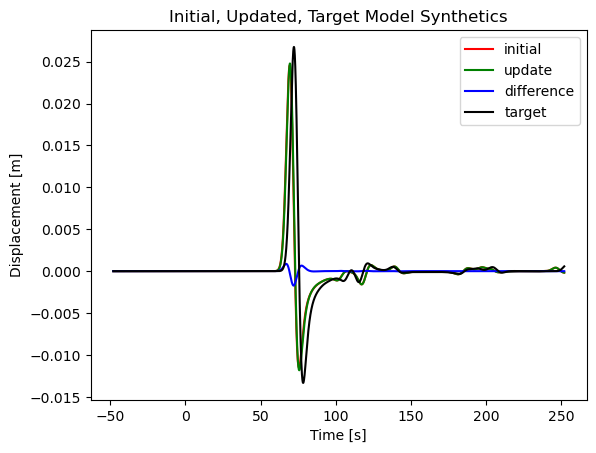

In [19]:
# Load in Target model synthetics
t_true, d_true = np.loadtxt("MODEL_TRUE/AA.S000000.BXY.semd").T

# Plot the same as before
plot_waveforms(t=t_init, data=[d_init, d_update, d_diff, d_true],
               labels=["initial", "update", "difference", "target"],
               colors=["r", "g", "b", "k"])

plt.title("Initial, Updated, Target Model Synthetics")
plt.show()

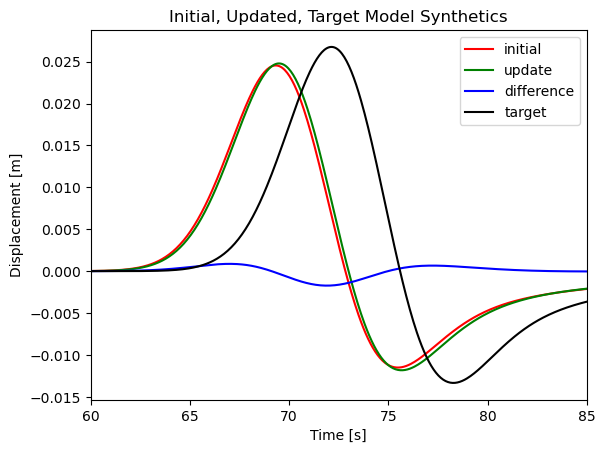

In [20]:
# Load in Target model synthetics
t_true, d_true = np.loadtxt("MODEL_TRUE/AA.S000000.BXY.semd").T

# Plot the same as before
plot_waveforms(t=t_init, data=[d_init, d_update, d_diff, d_true],
               labels=["initial", "update", "difference", "target"],
               colors=["r", "g", "b", "k"])

plt.title("Initial, Updated, Target Model Synthetics")
plt.xlim([60, 85])
plt.show()

#### Understanding waveform differences
- Target model synthetics (black) are *delayed* compared to initial model synthetics (red), by approximately 3s
- Target model synthetics (black) show *larger* amplitudes compared to initial model synthetics (red)
- By visual inspection, the updated model synthetics (green) appear to be moving *towards* the target synthetics (black)
- Visual inspection is a qualitative measure, we would prefer to **quantify** waveform misfit 

### c) Quantfiying Waveform Misfit

- Waveform misfit: $ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~$  (as in Day 2)
- In the equation above: $d(t)$ is 'data' and $s(t)$ is 'synthetics'
- **Objective**: Determine if the model update has reduced waveform misfit w.r.t initial model

In [21]:
# Represents the time step, or `dt`. Same for all waveforms
dt = t_true[1] - t_true[0]  

# Use Simpson's rule for integration
misfit_init = 1/2 * simps((d_true - d_init)**2, dx=dt)
misfit_update = 1/2 * simps((d_true - d_update)**2, dx=dt)

print(f"misfit_init = {misfit_init:.3E}")
print(f"misfit_true = {misfit_update:.3E}")
print(f"init - true = {misfit_init - misfit_update:.3E}")
print(f"was misfit reduced? -> {bool(misfit_init > misfit_update)}")

misfit_init = 1.453E-03
misfit_true = 1.332E-03
init - true = 1.213E-04
was misfit reduced? -> True


---------------

**Mission accomplished!**
- We have successfully reduced the waveform misfit for a single source receiver pair by updating our velocity model.
- The misfit reduction is relatively small; this value is tied to the gradient and chosen scale factor $\alpha$
- We could increase the scale factor to achieve a more favorable misfit reduction, however if we go too far, we may end up increasing the misfit.
- Algorithmically, this step is defined as the `line search`, which attempts to search for an appropriate scale factor for model update
- There are many types of nonlinear optimization algorithms (e.g., gradient descent, L-BFGS) which are used to determine scale factors in an effort to minimize misfit
- **NOTE** each evaluation of a line search requires **re-running** the forward simulation with a trial model, it is therefore ideal to find the best performing algorithm to keep computational costs down 
- See e.g., [Modrak and Tromp (2016)](https://academic.oup.com/gji/article/206/3/1864/2583505) for exploration of how various algorithms perform in the context of seismic inverison
